In [1]:
#food recommendation with gnn

In [2]:
recipe_path='mini_recipe.csv'
users_path='mini_ratings.csv'

import pandas as pd
recdf=pd.read_csv(recipe_path).head()
userdf=pd.read_csv(users_path).head()

In [3]:
recdf

,name,id,tags,steps,description,ingredients
0,arriba baked winter squash mexican style,1,"'60-minutes-or-less', 'time-to-make', 'course'...","['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ..."
1,a bit different breakfast pizza,2,"'30-minutes-or-less', 'time-to-make', 'course'...","['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg..."
2,all in the kitchen chili,3,"'time-to-make', 'course', 'preparation', 'main...","['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato..."
3,alouette potatoes,4,"'60-minutes-or-less', 'time-to-make', 'course'...",['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n..."
4,amish tomato ketchup for canning,5,"'weeknight', 'time-to-make', 'course', 'main-i...",['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar..."


In [4]:
userdf

,user_id,recipe_id,rating
0,1,104,5
1,1,4,5
2,1,65,4
3,1,157,4
4,1,192,4


In [5]:
import torch
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero

from sentence_transformers import SentenceTransformer

from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit, ToUndirected


In [6]:
def load_node_csv(path, index_col,usecols, encoders=None, **kwargs):
    df = pd.read_csv(path, index_col=index_col,usecols=usecols, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [7]:
class IdentityEncoder(object):
    # The 'IdentityEncoder' takes the raw column values and converts them to
    # PyTorch tensors.
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)

In [8]:
user_x, user_mapping = load_node_csv(users_path, index_col='user_id',usecols=['user_id','recipe_id','rating'])

In [9]:
from sentence_transformers import SentenceTransformer
class SequenceEncoder(object):
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        return x.cpu()

In [10]:
#pretrained nlp based on this paper : https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
model = SentenceTransformer('all-MiniLM-L6-v2')
'''It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.'''
#Sentences are encoded by calling model.encode()
embedding = model.encode('all in the kitchen chili')
print("Sentence:", 'all in the kitchen chili')
print("Embedding:", embedding)


Sentence: all in the kitchen chili
Embedding: [-5.51931374e-03 -4.10158262e-02 -3.01967524e-02  3.93164791e-02
  5.11999503e-02  3.80376764e-02 -2.34378092e-02 -3.02108414e-02
  7.04930648e-02 -4.36755940e-02  8.55849683e-02 -9.81658325e-02
  3.58096957e-02 -4.72344160e-02  4.01315577e-02 -1.22511886e-01
  6.59602806e-02 -4.63774521e-03 -2.45440775e-03 -1.37929514e-01
 -7.20611736e-02  4.17015739e-02 -1.59377996e-02 -6.38620288e-04
 -2.45632268e-02  8.04624557e-02 -1.60863437e-02  2.40566954e-02
 -3.32883210e-03 -4.27250154e-02 -1.15168504e-02  2.07392648e-02
 -8.96550249e-03  3.21191642e-03  5.12182750e-02 -3.47967669e-02
  1.47190783e-02 -7.44249597e-02  9.94519293e-02  8.59277137e-03
 -3.42518440e-03 -3.96949798e-02  3.18371877e-02 -8.91383830e-03
  8.55277702e-02  4.40576114e-03 -4.20175642e-02 -6.01205826e-02
  1.00773156e-01 -6.35126904e-02 -6.00883737e-04  1.43237999e-02
  1.63326925e-03  1.29496098e-01  3.57698910e-02  1.70875378e-02
 -4.68379492e-03 -9.75739136e-02  5.23349904

In [11]:
sentence="I like apples"
embedding = model.encode(sentence)
print("Sentence:", sentence)
print("Embedding:", embedding)


Sentence: I like apples
Embedding: [-2.88904291e-02  4.64452524e-03 -5.30242780e-03  3.52192707e-02
 -4.06657718e-02 -1.29475649e-02  1.21806540e-01  3.15719889e-03
  4.40227501e-02  3.67142558e-02  3.55952606e-02 -6.54208362e-02
  2.92756706e-02 -1.27371959e-02  3.32819670e-02  6.80304365e-03
  6.32420778e-02 -2.34737415e-02 -7.45559409e-02 -1.54757127e-02
 -9.87771004e-02  7.67397359e-02  3.68429422e-02 -1.34928413e-02
 -2.34488044e-02  4.48818170e-02  2.33373120e-02 -3.16783600e-02
 -6.03630692e-02 -4.49833833e-02 -5.64909913e-02  4.92774881e-03
  3.71788926e-02  1.46238273e-02 -3.53759788e-02  6.13850076e-03
  9.34081301e-02 -2.22493522e-02 -2.36315951e-02 -1.40833091e-02
  1.76917808e-03  4.20292020e-02  5.73835932e-02  3.68856043e-02
 -5.40421121e-02 -2.27117143e-03  3.16332504e-02 -5.18125445e-02
  9.41365585e-02  6.85070455e-02  6.34812713e-02 -7.86271587e-04
 -3.47687565e-02 -5.23898304e-02  2.60587223e-02  3.08203883e-02
  2.01874990e-02  1.35271149e-02  5.07006533e-02 -2.634

In [12]:
#tags are mapped to numbers and substituted to get vector form
class TagsEncoder(object):
    def __init__(self, sep=','):
        self.sep = sep

    def __call__(self, df):
        tags = set(g for col in df.values for g in col.split(self.sep))
        mapping = {tags: i for i, tags in enumerate(tags)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for tags in col.split(self.sep):
                x[i, mapping[tags]] = 1
        print(mapping)
        return x

In [13]:
recipe_x,recipe_mapping = load_node_csv(
    recipe_path,index_col='id',usecols=['id','name','tags'],encoders={
        'name': SequenceEncoder(),
        'tags': TagsEncoder()
    })

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

{" 'winter'": 0, " 'salmon'": 1, " 'brunch'": 2, " 'german'": 3, " 'egg-free'": 4, " 'spreads'": 5, " 'saltwater-fish'": 6, " 'polish'": 7, " 'rolled-cookies'": 8, " 'kid-friendly'": 9, " 'fruit'": 10, " 'lasagna'": 11, " 'pork-chops'": 12, " 'no-cook'": 13, " 'sandwiches'": 14, " 'beef'": 15, " 'heirloom-historical'": 16, " 'mushrooms'": 17, " 'desserts'": 18, " 'soups-stews'": 19, " 'potluck'": 20, " 'grilling'": 21, " 'tomatoes'": 22, " 'gumbo'": 23, " 'corn'": 24, " 'peppers'": 25, " 'leftovers'": 26, " 'pizza'": 27, " 'eggs-dairy'": 28, " 'chicken'": 29, " 'pork-ribs'": 30, " 'ground-beef'": 31, " 'smoothies'": 32, " 'bar-cookies'": 33, " 'food-processor-blender'": 34, " 'savory-sauces'": 35, " 'course'": 36, " 'easy'": 37, " 'inexpensive'": 38, " 'hawaiian'": 39, " 'snacks'": 40, " 'no-shell-fish'": 41, " 'refrigerator'": 42, " 'savory'": 43, " 'wedding'": 44, " 'main-ingredient'": 45, " 'clear-soups'": 46, " 'chicken-breasts'": 47, " 'asparagus'": 48, " 'technique'": 49, " 'diet

In [14]:
def load_edge_csv(path,usecols, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  encoders=None, **kwargs):
    df = pd.read_csv(path,usecols=usecols, **kwargs)

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [15]:
edge_index, edge_label = load_edge_csv(
    users_path,
    usecols=['user_id','recipe_id','rating'],
    src_index_col='user_id',
    src_mapping=user_mapping,
    dst_index_col='recipe_id',
    dst_mapping=recipe_mapping,
    encoders={'rating': IdentityEncoder(dtype=torch.long)},
)


In [16]:
data =HeteroData()
data['user'].num_nodes = len(user_mapping)  # Users do not have any features.
data['recipe'].x = recipe_x
data['user', 'rates', 'recipe'].edge_index = edge_index
data['user', 'rates', 'recipe'].edge_label = edge_label
print(data)

HeteroData(
  user={ num_nodes=250 },
  recipe={ x=[200, 654] },
  (user, rates, recipe)={
    edge_index=[2, 3000],
    edge_label=[3000, 1]
  }
)


In [17]:
import argparse
import sys
sys.argv = ['']

In [18]:
parser = argparse.ArgumentParser()
parser.add_argument('--use_weighted_loss', action='store_true',
                    help='Whether to use weighted MSE loss.')
args = parser.parse_args()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
data = data.to(device)

In [21]:
#user fatures
df=pd.read_csv('user.csv',usecols=['age','gender','veg','height','weight'])
df

,age,gender,veg,height,weight
0,70,0,0,210,118
1,60,1,0,175,108
2,70,1,0,175,79
3,70,1,1,198,98
4,39,1,0,210,93
...,...,...,...,...,...
245,45,0,0,169,51
246,24,1,0,161,77
247,50,1,0,203,48
248,57,0,1,167,75


In [22]:
a=df.values.tolist()

In [23]:
data['user'].x = torch.tensor(a,dtype=torch.float, device=device)
del data['user'].num_nodes

In [24]:
data = T.ToUndirected()(data)
del data['recipe', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In [25]:
transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'recipe')],
    rev_edge_types=[('recipe', 'rev_rates', 'user')],
)
train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)

HeteroData(
  user={ x=[250, 5] },
  recipe={ x=[200, 654] },
  (user, rates, recipe)={
    edge_index=[2, 2550],
    edge_label=[2550, 1],
    edge_label_index=[2, 2550]
  },
  (recipe, rev_rates, user)={ edge_index=[2, 2550] }
)
HeteroData(
  user={ x=[250, 5] },
  recipe={ x=[200, 654] },
  (user, rates, recipe)={
    edge_index=[2, 2550],
    edge_label=[150, 1],
    edge_label_index=[2, 150]
  },
  (recipe, rev_rates, user)={ edge_index=[2, 2550] }
)
HeteroData(
  user={ x=[250, 5] },
  recipe={ x=[200, 654] },
  (user, rates, recipe)={
    edge_index=[2, 2700],
    edge_label=[300, 1],
    edge_label_index=[2, 300]
  },
  (recipe, rev_rates, user)={ edge_index=[2, 2700] }
)


In [26]:
if args.use_weighted_loss:
    weight = torch.bincount(train_data['user', 'movie'].edge_label)
    weight = weight.max() / weight
else:
    weight = None


def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [27]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['recipe'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=50).to(device)


In [28]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [29]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'recipe'].edge_index)
    target = train_data['user', 'recipe'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

In [30]:
@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'recipe'].edge_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'recipe'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)


In [31]:
losses=[]
vallosses=[]
for epoch in range(1,300):
    loss = train()
    losses.append(loss)
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    vallosses.append(val_rmse)
    test_rmse = test(test_data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

C:\Users\saadn\AppData\Local\Temp/ipykernel_15852/1525611088.py:8: UserWarning: Using a target size (torch.Size([2550, 1])) that is different to the input size (torch.Size([2550])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
C:\Users\saadn\AppData\Local\Temp/ipykernel_15852/1525611088.py:8: UserWarning: Using a target size (torch.Size([150, 1])) that is different to the input size (torch.Size([2550])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
C:\Users\saadn\AppData\Local\Temp/ipykernel_15852/1525611088.py:8: UserWarning: Using a target size (torch.Size([300, 1])) that is different to the input size (torch.Size([2700])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()


Epoch: 001, Loss: 28.6644, Train: 4.2248, Val: 4.1231, Test: 4.2442
Epoch: 002, Loss: 4409.2632, Train: 4.2248, Val: 4.1231, Test: 4.2442
Epoch: 003, Loss: 23.2736, Train: 1.4246, Val: 1.5055, Test: 1.4189
Epoch: 004, Loss: 351.2314, Train: 1.4246, Val: 1.5055, Test: 1.4189
Epoch: 005, Loss: 33.9066, Train: 4.2248, Val: 4.1231, Test: 4.2442
Epoch: 006, Loss: 78.3853, Train: 4.2248, Val: 4.1231, Test: 4.2442
Epoch: 007, Loss: 72.7958, Train: 1.4246, Val: 1.5055, Test: 1.4189
Epoch: 008, Loss: 22.4094, Train: 1.4246, Val: 1.5055, Test: 1.4189
Epoch: 009, Loss: 71.1379, Train: 1.5513, Val: 1.4866, Test: 1.5696
Epoch: 010, Loss: 2.4067, Train: 4.2248, Val: 4.1231, Test: 4.2442
Epoch: 011, Loss: 39.5146, Train: 4.1552, Val: 4.0537, Test: 4.1750
Epoch: 012, Loss: 18.2847, Train: 1.4246, Val: 1.5055, Test: 1.4189
Epoch: 013, Loss: 5.2305, Train: 1.4246, Val: 1.5055, Test: 1.4189
Epoch: 014, Loss: 28.3716, Train: 1.4246, Val: 1.5055, Test: 1.4189
Epoch: 015, Loss: 8.2645, Train: 2.4779, Val: 2

Epoch: 129, Loss: 1.2012, Train: 1.0960, Val: 1.1118, Test: 1.1037
Epoch: 130, Loss: 1.2012, Train: 1.0960, Val: 1.1118, Test: 1.1037
Epoch: 131, Loss: 1.2011, Train: 1.0959, Val: 1.1132, Test: 1.1034
Epoch: 132, Loss: 1.2010, Train: 1.0959, Val: 1.1138, Test: 1.1033
Epoch: 133, Loss: 1.2010, Train: 1.0958, Val: 1.1128, Test: 1.1034
Epoch: 134, Loss: 1.2009, Train: 1.0958, Val: 1.1118, Test: 1.1035
Epoch: 135, Loss: 1.2009, Train: 1.0958, Val: 1.1120, Test: 1.1034
Epoch: 136, Loss: 1.2008, Train: 1.0958, Val: 1.1131, Test: 1.1033
Epoch: 137, Loss: 1.2007, Train: 1.0958, Val: 1.1134, Test: 1.1032
Epoch: 138, Loss: 1.2007, Train: 1.0957, Val: 1.1125, Test: 1.1033
Epoch: 139, Loss: 1.2006, Train: 1.0957, Val: 1.1118, Test: 1.1034
Epoch: 140, Loss: 1.2006, Train: 1.0957, Val: 1.1122, Test: 1.1033
Epoch: 141, Loss: 1.2005, Train: 1.0957, Val: 1.1130, Test: 1.1031
Epoch: 142, Loss: 1.2005, Train: 1.0956, Val: 1.1130, Test: 1.1031
Epoch: 143, Loss: 1.2004, Train: 1.0956, Val: 1.1122, Test: 1.

Epoch: 253, Loss: 1.1968, Train: 1.0940, Val: 1.1109, Test: 1.1016
Epoch: 254, Loss: 1.1968, Train: 1.0940, Val: 1.1109, Test: 1.1016
Epoch: 255, Loss: 1.1968, Train: 1.0940, Val: 1.1109, Test: 1.1016
Epoch: 256, Loss: 1.1968, Train: 1.0940, Val: 1.1109, Test: 1.1016
Epoch: 257, Loss: 1.1967, Train: 1.0939, Val: 1.1109, Test: 1.1015
Epoch: 258, Loss: 1.1967, Train: 1.0939, Val: 1.1108, Test: 1.1015
Epoch: 259, Loss: 1.1967, Train: 1.0939, Val: 1.1108, Test: 1.1015
Epoch: 260, Loss: 1.1967, Train: 1.0939, Val: 1.1108, Test: 1.1015
Epoch: 261, Loss: 1.1966, Train: 1.0939, Val: 1.1108, Test: 1.1015
Epoch: 262, Loss: 1.1966, Train: 1.0939, Val: 1.1108, Test: 1.1015
Epoch: 263, Loss: 1.1966, Train: 1.0939, Val: 1.1108, Test: 1.1015
Epoch: 264, Loss: 1.1966, Train: 1.0939, Val: 1.1108, Test: 1.1015
Epoch: 265, Loss: 1.1966, Train: 1.0939, Val: 1.1108, Test: 1.1015
Epoch: 266, Loss: 1.1965, Train: 1.0939, Val: 1.1108, Test: 1.1015
Epoch: 267, Loss: 1.1965, Train: 1.0938, Val: 1.1108, Test: 1.

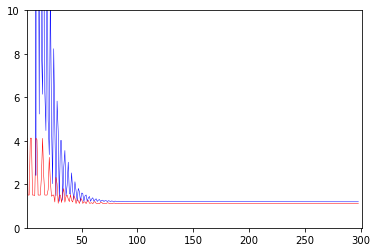

In [32]:
import matplotlib.pyplot as plt
plt.axis([1,301, 0, 10])
plt.plot(losses, 'b', label='train',lw=0.5)
plt.plot(vallosses, 'r',label='val',lw=0.5)
plt.rcParams["figure.figsize"] = 10,3
plt.show()

In [33]:
torch.save(model.state_dict(),'model.pth')

In [34]:
#recipe_x,recipe_mapping
import pickle
varfile=open('varfile.pickle','wb')
pickle.dump([recipe_x,recipe_mapping,user_x,user_mapping,a],varfile)
varfile.close()